In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib import pyplot as plt
import seaborn as sns

import humanize

sns.set_style('white')
%matplotlib inline

In [2]:
axis_color = "0.4"
non_accent_light = "#dbdbdb"
non_accent_medium = "#bdbdbd"
non_accent_dark = "#a8a8a8"
accent = "#4599ff"
palette = sns.color_palette([non_accent_medium,accent])

In [3]:
def format_chart_axes(title,axes,x_label_format='{:,.1f}',x_label_scale=1,y_label_format='{:,.1f}',y_label_scale=1,color="black"):
    plt.title(title,y=1.05, color=color)

    axes.set_xticks(axes.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
    axes.set_xticklabels([x_label_format.format(x) for x in (axes.get_xticks()/x_label_scale).tolist()])
    
    axes.set_yticks(axes.get_yticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
    axes.set_yticklabels([y_label_format.format(x) for x in (axes.get_yticks()/y_label_scale).tolist()])

    axes.spines['bottom'].set_color(color)
    axes.xaxis.label.set_color(color)
    axes.tick_params(axis='x', colors=color)

    axes.spines['left'].set_color(color)
    axes.yaxis.label.set_color(color)
    axes.tick_params(axis='y', colors=color)

    sns.despine()    

## Data processing

In [63]:
econ_df = pd.DataFrame()
gambling_df = pd.DataFrame()
tnl_df  = pd.DataFrame()
hist_df = pd.DataFrame()

In [64]:
temp = pd.read_csv('./data/ABMI-290920.csv')

temp = temp[temp['Title'].str.isnumeric()]

temp.columns = ['year','GDP']

temp['GDP'] = pd.to_numeric(temp['GDP'])
temp['year'] = pd.to_numeric(temp['year'])
#temp['GDP growth'] = temp['GDP'].pct_change()

temp.index = temp['year']
temp = temp.drop('year',axis=1)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)

In [65]:
temp = pd.read_csv('./data/QWND-290920.csv')

temp = temp[temp['Title'].str.isnumeric()]

temp.columns = ['year','disposable income']

temp['disposable income'] = pd.to_numeric(temp['disposable income'])
temp['year'] = pd.to_numeric(temp['year'])
#temp['disposable income growth'] = temp['disposable income'].pct_change()

temp.index = temp['year']
temp = temp.drop('year',axis=1)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)

In [66]:
temp = pd.read_csv('./data/marketdata.csv')
temp.index = temp['Year']
temp = temp.drop('Year',axis=1)


gambling_df = pd.concat(
    [gambling_df,
     temp[[
        'Gambling GGY',
        'Total gambling participation']].loc[:2019]
    ]
)

gambling_df.columns = [
    'gambling GGY',
    'gambling players']

        
tnl_df = pd.concat(
    [tnl_df,
     temp[['TNL GGY',
           'TNL participation']].loc[:2019]
    ]
)

tnl_df.columns = [
    'TNL GGY', 
    'TNL players']

In [67]:
hist_df = pd.merge(
        econ_df,
        gambling_df,
        left_index=True,
        right_index=True,
        how='outer',
)

hist_df = pd.merge(
        hist_df,
        tnl_df,
        left_index=True,
        right_index=True,
        how='outer',
)

hist_df.index = hist_df.index.set_names('year')

## Monte Carlo Simulation

In [79]:
iterations = 750
years_to_project = 10
initial_year = 2020

In [87]:
projected_years = np.arange(initial_year,initial_year+years_to_project)

initial_GDP = hist_df.loc[initial_year-1]['GDP']
initial_TNL_share = hist_df.loc[initial_year-1]['TNL GGY'] / hist_df.loc[initial_year-1]['disposable income']

In [91]:
GDP_mean = 0.024383720592148272        #Historical average of YoY growth in the period from 1956 to 2019
GDP_std_dev = 0.020191051459338794     #Historical stdev of YoY growth in the period from 1956 to 2019

tnl_share_mean       = 0.0003997407239658791
tnl_share_std_dev    = 0.06419624024568973

In [92]:
projections_df = pd.DataFrame()


projected_GDP_growth = np.random.normal(GDP_mean, GDP_std_dev, years_to_project)
projected_tnl_share_growth = np.random.normal(tnl_share_mean, tnl_share_std_dev, years_to_project)

tmp_df = pd.DataFrame()

tmp_df['year'] = projected_years

tmp_df['GDP'] = 1
tmp_df['TNL share'] = 1

tmp_df['GDP growth'] = projected_GDP_growth
tmp_df['TNL share growth'] = projected_tnl_share_growth

GDP_growth_factor = tmp_df['GDP growth'] + 1
tnl_share_growth_factor = tmp_df['TNL share growth'] + 1

for i in range(years_to_project):
    tmp_df['GDP'] = tmp_df['GDP'] * GDP_growth_factor.shift(i,fill_value=1)
    tmp_df['TNL share'] = tmp_df['TNL share'] * tnl_share_growth_factor.shift(i,fill_value=1)

    
tmp_df['GDP'] *= initial_GDP
tmp_df['TNL share'] *= initial_TNL_share


tmp_df['disposable income'] = (-575967.8405697127 + (tmp_df['GDP'] * 0.914156951026817))
tmp_df['TNL GGY'] = 

In [93]:
tmp_df

,year,GDP,TNL share,GDP growth,TNL share growth,disposable income
0,2020,2.129208e+06,0.002507,0.018452,0.090090,1.370462e+06
1,2021,2.167957e+06,0.002591,0.018199,0.033471,1.405885e+06
2,2022,2.231853e+06,0.002770,0.029473,0.069297,1.464296e+06
3,2023,2.320283e+06,0.002964,0.039622,0.070059,1.545135e+06
4,2024,2.318147e+06,0.002509,-0.000920,-0.153692,1.543183e+06
5,2025,2.350132e+06,0.002664,0.013797,0.061944,1.572421e+06
6,2026,2.437006e+06,0.002512,0.036966,-0.057090,1.651838e+06
7,2027,2.462973e+06,0.002654,0.010655,0.056378,1.675576e+06
8,2028,2.520886e+06,0.002510,0.023513,-0.054202,1.728517e+06
9,2029,2.555517e+06,0.002571,0.013738,0.024505,1.760176e+06


## Sandbox

### Tutorial example of a regression model using scikit-learn

In [13]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [14]:
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)
diabetes_X = diabetes_X[:, np.newaxis, 2]

In [15]:
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

In [16]:
regr = linear_model.LinearRegression()

In [17]:
regr.fit(diabetes_X_train,diabetes_y_train)

LinearRegression()

In [18]:
diabetes_y_predict = regr.predict(diabetes_X_test)

In [19]:
regr.coef_

array([938.23786125])

In [20]:
mean_squared_error(diabetes_y_test,diabetes_y_predict)

2548.0723987259694

In [21]:
r2_score(diabetes_y_test,diabetes_y_predict)

0.47257544798227147

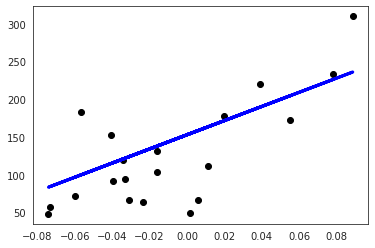

In [22]:
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_predict, color='blue', linewidth=3)

### Regression of historical GDP vs Disposable Income

In [23]:
regr = linear_model.LinearRegression()

In [24]:
regr.fit(econ_df['GDP'].to_numpy().reshape(-1,1),econ_df['disposable income'])

LinearRegression()

In [25]:
disp_income_predict = regr.predict(econ_df['GDP'].to_numpy().reshape(-1,1))

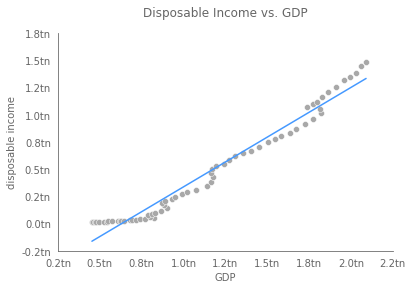

In [26]:
#plt.scatter(econ_df['GDP'].to_numpy().reshape(-1,1),econ_df['disposable income'],color='black')
#plt.plot(econ_df['GDP'].to_numpy().reshape(-1,1), disp_income_predict, color='blue', linewidth=3)

sns.scatterplot(x=econ_df['GDP'],
                y=econ_df['disposable income'],
                color=non_accent_dark)
ax = sns.lineplot(x=econ_df['GDP'],
             y=disp_income_predict,
            color=accent)

format_chart_axes("Disposable Income vs. GDP",
                  ax,
                  x_label_scale=1000000,
                  x_label_format='{:,.1f}tn',
                  y_label_scale=1000000,
                  y_label_format='{:,.1f}tn',
                  color=axis_color)

In [27]:
r2 = round(r2_score(econ_df['disposable income'],disp_income_predict),2)
intercept = humanize.intcomma(regr.intercept_,1)
coefficient = humanize.intcomma(regr.coef_[0],2)

##### Disposable Income vs GDP

Disposable Income = {{intercept}} + {{coefficient}} * GDP

The regression has an R2 of {{r2}} 

### Historical behaviour: GDP YoY change

In [29]:
used = np.random.normal(GDP_mean, GDP_std_dev, 500)

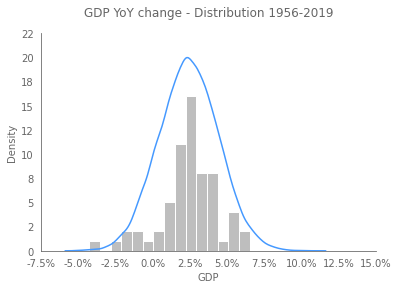

In [30]:
ax = sns.kdeplot(np.random.normal(GDP_mean, GDP_std_dev, 25000),
                  color=accent)
ax = sns.histplot(hist_df['GDP'].pct_change(),
                  bins=15,
                  color=non_accent_dark)
format_chart_axes("GDP YoY change - Distribution 1956-2019",
                  ax,
                  x_label_format='{:,.1%}',
                  y_label_format='{:,.0f}',
                  color=axis_color)

In [31]:
gdp_yoy_change_mean = '{:.2%}'.format(hist_df['GDP'].pct_change().mean())

In [32]:
gdp_yoy_change_stdev = '{:.2%}'.format(hist_df['GDP'].pct_change().std())

##### GDP YoY change historical behaviour (1956-2019)

Average YoY GDP change {{gdp_yoy_change_mean}}

Yoy GDP change Standard Deviation {{gdp_yoy_change_stdev}}

### Historical behaviour: TNL market share change

In [88]:
hist_df.tail(12)
tnl_share = hist_df['TNL GGY']/hist_df['disposable income']
tnl_share_yoy_change_mean = tnl_share.pct_change().mean()
tnl_share_yoy_change_stdev = tnl_share.pct_change().std()


In [90]:
tnl_share_yoy_change_mean

0.0003997407239658791